In [69]:
# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from PIL import ImageDraw
import datasets
from datasets import load_dataset

In [70]:
source_path="./data/decodinglab/placedata.npy"
# --- 3. Load and Process Data ---
print(f"\nAttempting to load data from: {source_path}")

try:
    # Load the .npy file.
    # allow_pickle=True is necessary for loading object arrays, like dictionaries.
    # .item() is used to extract the dictionary object that was saved into the file.
    loaded_data = np.load(source_path, allow_pickle=True).item()
    print("File loaded successfully.")

    # --- 4. Extract Variables from the Dictionary ---
    # We extract each variable by using its name as a key in the loaded dictionary.
    # Note that we are now using 'RLtesttgt' as the key.
    LRtrain = loaded_data['LRtrain']
    LRtest = loaded_data['LRtest']
    RLtest = loaded_data['RLtest']
    LRtraintgt = loaded_data['LRtraintgt']
    LRtesttgt = loaded_data['LRtesttgt']
    RLtesttgt = loaded_data['RLtesttgt'] # <-- Using the new, renamed variable

    print("\nSuccessfully extracted all variables. Shapes:")
    print(f"  LRtrain:    {LRtrain.shape}")
    print(f"  LRtest:     {LRtest.shape}")
    print(f"  RLtest:     {RLtest.shape}")
    print(f"  LRtraintgt: {LRtraintgt.shape}")
    print(f"  LRtesttgt:  {LRtesttgt.shape}")
    print(f"  RLtesttgt:  {RLtesttgt.shape}") # <-- Updated variable name

    # --- 5. Find and Print Unique Labels ---
    # The np.unique() function returns the sorted unique elements of an array.
    print("\n" + "="*40)
    print("Analyzing unique labels in target vectors...")
    print("="*40)

    unique_train_labels = np.unique(LRtraintgt)
    print(f"Unique labels in LRtraintgt: {unique_train_labels}")

    unique_test_lr_labels = np.unique(LRtesttgt)
    print(f"Unique labels in LRtesttgt:  {unique_test_lr_labels}")

    unique_test_rl_labels = np.unique(RLtesttgt) # <-- Using the new, renamed variable
    print(f"Unique labels in RLtesttgt:   {unique_test_rl_labels}") # <-- Updated label
    print("="*40)


# --- Error Handling ---
except FileNotFoundError:
    print(f"\n[ERROR] File Not Found: The file could not be found at '{source_path}'.")
    print("Please ensure that 'placedata_modified.npy' exists in the root of your 'My Drive'.")

except KeyError as e:
    print(f"\n[ERROR] Missing Data: The file was loaded, but a required variable key was not found: {e}.")
    print("Please check the script that created 'placedata_modified.npy' to ensure all 6 variables were saved correctly with the new names.")

except Exception as e:
    print(f"\n[ERROR] An unexpected error occurred: {e}")


Attempting to load data from: ./data/decodinglab/placedata.npy
File loaded successfully.

Successfully extracted all variables. Shapes:
  LRtrain:    (359, 916)
  LRtest:     (359, 904)
  RLtest:     (359, 1003)
  LRtraintgt: (916,)
  LRtesttgt:  (904,)
  RLtesttgt:  (1003,)

Analyzing unique labels in target vectors...
Unique labels in LRtraintgt: [0.         0.04545455 0.09090909 0.13636364 0.18181818 0.22727273
 0.27272727 0.31818182 0.36363636 0.40909091 0.45454545 0.5
 0.54545455 0.59090909 0.63636364 0.68181818 0.72727273 0.77272727
 0.81818182 0.86363636 0.90909091 0.95454545 1.        ]
Unique labels in LRtesttgt:  [0.         0.04545455 0.09090909 0.13636364 0.18181818 0.22727273
 0.27272727 0.31818182 0.36363636 0.40909091 0.45454545 0.5
 0.54545455 0.59090909 0.63636364 0.68181818 0.72727273 0.77272727
 0.81818182 0.86363636 0.90909091 0.95454545 1.        ]
Unique labels in RLtesttgt:   [0.         0.04545455 0.09090909 0.13636364 0.18181818 0.22727273
 0.27272727 0.318181

In [71]:
class PlacedataDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = torch.from_numpy(self.features[index]) 
        target = torch.tensor(self.targets[index], dtype=torch.float32)
        # print(f"feature: {feature}\ntarget: {target}")
        return feature, target
    
# For training data
# train_dataset = PlacedataDataset(LRtrain, LRtraintgt)
# # print(LRtraintgt)

# # For test data (left-to-right)
# test_lr_dataset = PlacedataDataset(LRtest, LRtesttgt)

# # For test data (right-to-left)
# test_rl_dataset = PlacedataDataset(RLtest, RLtesttgt)

train_dataset = PlacedataDataset(LRtrain.T, LRtraintgt)
test_lr_dataset = PlacedataDataset(LRtest.T, LRtesttgt)
test_rl_dataset = PlacedataDataset(RLtest.T, RLtesttgt)


batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_lr_loader = DataLoader(test_lr_dataset, batch_size=batch_size, shuffle=False)
test_rl_loader = DataLoader(test_rl_dataset, batch_size=batch_size, shuffle=False)

print(next(iter(train_loader)))

[tensor([[ 0.0140,  0.8540,  0.2255,  ..., -0.0739,  0.1865,  0.3363],
        [ 0.0140,  0.8466,  0.2166,  ..., -0.0521,  0.1832,  0.3211],
        [ 0.0140,  0.8349,  0.2074,  ..., -0.0369,  0.1793,  0.3018],
        ...,
        [ 0.0140,  0.4560,  0.1503,  ..., -0.0925,  0.2670,  0.0683],
        [ 0.0140,  0.4558,  0.1511,  ..., -0.0946,  0.2797,  0.0498],
        [ 0.0140,  0.4524,  0.1508,  ..., -0.0966,  0.2877,  0.0318]]), tensor([0.0455, 0.0455, 0.0455, 0.0455, 0.0909, 0.0909, 0.0909, 0.1364, 0.1364,
        0.1818, 0.2273, 0.2727, 0.3182, 0.3636, 0.3636, 0.4091, 0.4545, 0.5000,
        0.5455, 0.5909, 0.6364, 0.6364, 0.6818, 0.7273, 0.7727, 0.8182, 0.8182,
        0.8636, 0.9091, 0.9091, 0.9091, 0.9545])]


In [72]:
class SLP(nn.Module):
    def __init__(self):
        super(SLP, self).__init__()

        self.fc=nn.LazyLinear(1)

    def forward(self,x):
        x=self.fc(x)
        x = torch.sigmoid(x)
        return x

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5000
model = SLP().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    print(f"starting epoch {epoch}")

    # Train the model
    model.train()
    # inputs, targets = next(iter(train_loader))
    for count, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)  # << compute outputs first
        # print(f"inputs shape {inputs.shape} \n outputs.shape {outputs.shape}")

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch {epoch} loss: {loss.item()}")
    # Evaluate the model on test
    model.eval()
    with torch.no_grad():
        inputs, targets = next(iter(test_lr_loader))
        inputs=inputs.to(device)
        targets=targets.to(device)
        outputs = model(inputs)
        print(f"test epoch {epoch} loss: {criterion(outputs, targets).item()}")

starting epoch 0
epoch 0 loss: 0.15713191032409668
test epoch 0 loss: 0.23013128340244293
starting epoch 1
epoch 1 loss: 0.15366464853286743
test epoch 1 loss: 0.22513389587402344
starting epoch 2
epoch 2 loss: 0.15015539526939392
test epoch 2 loss: 0.22045278549194336
starting epoch 3
epoch 3 loss: 0.14666204154491425
test epoch 3 loss: 0.2160239815711975
starting epoch 4
epoch 4 loss: 0.14319345355033875
test epoch 4 loss: 0.2118278443813324
starting epoch 5
epoch 5 loss: 0.13975875079631805
test epoch 5 loss: 0.20784614980220795
starting epoch 6
epoch 6 loss: 0.1363670974969864
test epoch 6 loss: 0.204061359167099
starting epoch 7
epoch 7 loss: 0.13302679359912872
test epoch 7 loss: 0.20045721530914307
starting epoch 8
epoch 8 loss: 0.1297450214624405
test epoch 8 loss: 0.19701874256134033
starting epoch 9
epoch 9 loss: 0.1265277862548828
test epoch 9 loss: 0.19373250007629395
starting epoch 10
epoch 10 loss: 0.12337998300790787
test epoch 10 loss: 0.1905864030122757
starting epoch 

/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 14 loss: 0.11154691129922867
test epoch 14 loss: 0.1792028695344925
starting epoch 15
epoch 15 loss: 0.10878702253103256
test epoch 15 loss: 0.17661604285240173
starting epoch 16
epoch 16 loss: 0.10610772669315338
test epoch 16 loss: 0.17411935329437256
starting epoch 17
epoch 17 loss: 0.10350875556468964
test epoch 17 loss: 0.17170730233192444
starting epoch 18
epoch 18 loss: 0.1009894534945488
test epoch 18 loss: 0.16937494277954102
starting epoch 19
epoch 19 loss: 0.09854886680841446
test epoch 19 loss: 0.16711777448654175
starting epoch 20
epoch 20 loss: 0.09618573635816574
test epoch 20 loss: 0.16493186354637146
starting epoch 21
epoch 21 loss: 0.09389861673116684
test epoch 21 loss: 0.16281351447105408
starting epoch 22
epoch 22 loss: 0.09168587625026703
test epoch 22 loss: 0.16075947880744934
starting epoch 23
epoch 23 loss: 0.08954576402902603
test epoch 23 loss: 0.1587667465209961
starting epoch 24
epoch 24 loss: 0.08747643232345581
test epoch 24 loss: 0.1568325906991958

In [80]:
# Evaluate trained model
model.eval()
correct = 0
total = 0
total_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_lr_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

avg_loss = total_loss / len(test_lr_loader)
accuracy = correct / total

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Loss: 0.2114
Test Accuracy: 15.38%


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Predicted: [15 15 14 14 14]
Target:    [0 0 0 0 0]
Predicted: [11 11 12 12 13]
Target:    [11 12 13 14 15]
Predicted: [0 0 0 0 1]
Target:    [0 0 1 1 1]
Predicted: [19 19 19 19 19]
Target:    [20 21 21 21 21]
Predicted: [4 5 5 6 6]
Target:    [2 2 2 3 3]
Predicted: [21 21 21 21 21]
Target:    [21 21 21 21 21]
Predicted: [3 4 5 6 7]
Target:    [ 7  8  8  9 10]
Predicted: [0 0 0 0 0]
Target:    [0 0 0 0 0]
Predicted: [10 12 14 15 16]
Target:    [13 14 15 16 17]
Predicted: [19 19 20 19 18]
Target:    [22 22 22 22 22]
Predicted: [0 0 0 0 0]
Target:    [2 2 2 3 4]
Predicted: [5 6 7 7 8]
Target:    [21 21 21 21 21]
Predicted: [1 1 1 1 1]
Target:    [1 1 2 2 3]
Predicted: [16 16 17 17 17]
Target:    [21 21 21 21 21]
Predicted: [11 10  9 10 11]
Target:    [3 3 4 5 5]
Predicted: [21 22 22 22 22]
Target:    [21 21 21 21 21]
Predicted: [6 6 7 8 9]
Target:    [12 13 14 14 15]
Predicted: [18 18 17 17 17]
Target:    [1 1 1 2 2]
Predicted: [22 22 22 22 22]
Target:    [21 21 21 21 21]
Predicted: [5 5 

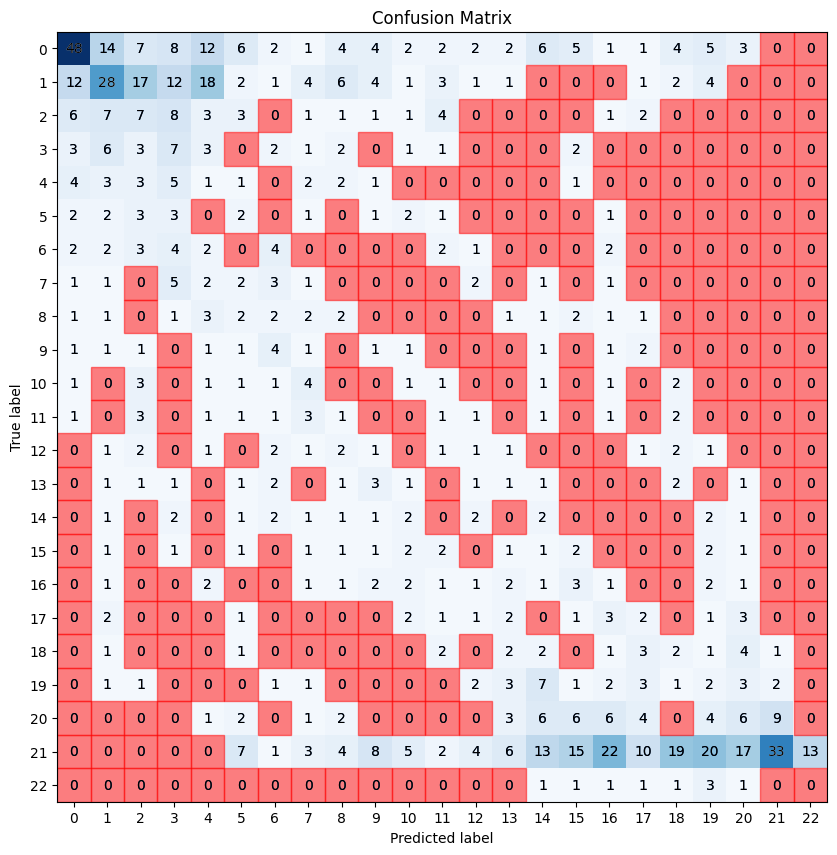

In [81]:
# ... existing imports ...
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ... existing code ...

# Evaluation
model.eval()
correct = 0
total = 0
total_loss = 0.0
all_preds = []
all_targets = []

NUM_CLASSES = 23
with torch.no_grad():
    for inputs, targets in test_lr_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Bin continuous outputs and targets into discrete class indices
        pred_classes = torch.clamp((outputs.squeeze() * NUM_CLASSES).long(), max=NUM_CLASSES - 1)
        target_classes = torch.clamp((targets.squeeze() * NUM_CLASSES).long(), max=NUM_CLASSES - 1)

        # Print first 5 elements
        print("Predicted:", pred_classes[:5].cpu().numpy())
        print("Target:   ", target_classes[:5].cpu().numpy())

        correct += (pred_classes == target_classes).sum().item()
        total += targets.size(0)

        all_preds.extend(pred_classes.cpu().numpy())
        all_targets.extend(target_classes.cpu().numpy())

# Metrics
avg_loss = total_loss / len(test_lr_loader)
accuracy = correct / total

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# # Confusion matrix
# cm = confusion_matrix(all_targets, all_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()
# Confusion matrix
# cm = confusion_matrix(all_targets, all_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# fig, ax = plt.subplots(figsize=(10, 10))
# disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

# # Customize text colors: red for zeros, black otherwise
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         val = cm[i, j]
#         color = 'red' if val == 0 else 'black'
#         ax.text(j, i, str(val), ha='center', va='center', color=color)

# plt.title("Confusion Matrix")
# plt.show()
# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, colorbar=False, cmap=plt.cm.Blues)

# Overlay red background for zeros
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] == 0:
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='red', alpha=0.5))
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.title("Confusion Matrix")
plt.show()
